# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

With the growing job market, it makes both employers and the employee life easier if the job postings are used to estimate the salary range. Employers will come to know the industry average for that position. Employee can be confident before-hand that his skills, experience and work achieves right value.

In [223]:
# Analysis libraries
import pandas as pd
import sklearn as sk
import numpy as np
from scipy import stats
import joblib

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from dython import nominal

# sklearn libraties
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

#My info
__author__ = "Sai Lalitha R"
__email__ = "sailalitha.r@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [252]:
#load the data into a Pandas dataframe

#train data
train_features=pd.read_csv("/Users/sailalithasadhu/Desktop/DSDJ/Projects/SalaryPredictions/salaryprediction/data/train_features.csv")
train_salaries=pd.read_csv("/Users/sailalithasadhu/Desktop/DSDJ/Projects/SalaryPredictions/salaryprediction/data/train_salaries.csv")

#test data
test_features=pd.read_csv("/Users/sailalithasadhu/Desktop/DSDJ/Projects/SalaryPredictions/salaryprediction/data/test_features.csv")

#merging train data sets into dataframe
df = train_features.merge(train_salaries, how='inner',on='jobId')
df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [115]:
df.shape

(1000000, 9)

### ---- 3 Clean the data ----

Check for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

In [116]:
#checking datatypes of columns
df.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [117]:
#checking for duplicate data
df.duplicated().sum()

0

In [118]:
#checking for NaN values
df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [119]:
#checking for invalid data (salary <=0 and removing the row)
df.drop(df[df['salary'] <= 0].index,inplace=True)
df.shape

(999995, 9)

The data is checked for correct datatypes of columns, duplicate data, NaN values and invalid data where salary column is <=0. There are 5 rows with invalid data. Those are removed and now this clean data can be used for data analysis.

### ---- 4 Explore the data (EDA) ----

In [120]:
#summarize numeric feature variable
df.describe()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [123]:
#summarize categorical feature variables
df.describe(include='object')

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362684660145,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


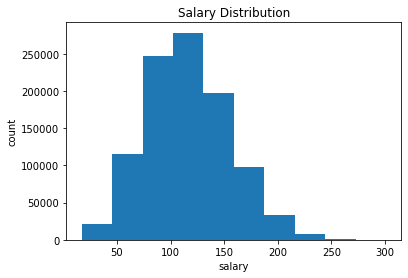

In [121]:
#summarize the target variable
plt.hist(x = 'salary', data=df)
plt.xlabel('salary')
plt.ylabel('count')
plt.title('Salary Distribution')
plt.show()

In [124]:
#count of salaries above 200
df[df['salary'] > 200]['jobType'].value_counts()

CEO               8574
CTO               4843
CFO               4735
VICE_PRESIDENT    2380
MANAGER           1049
SENIOR             397
JUNIOR             159
Name: jobType, dtype: int64

Most of the salaries above 200 value are for CEO, CTO, CFO job types rather than Janitor

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000672,0.375013
milesFromMetropolis,0.000672,1.000000,-0.297686
salary,0.375013,-0.297686,1.000000


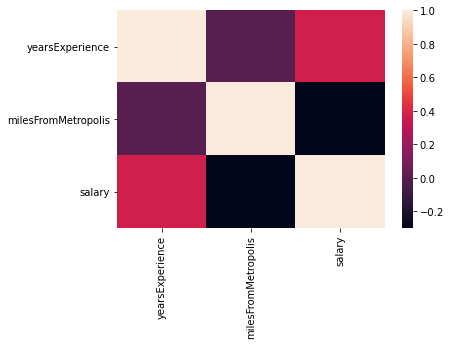

In [125]:
#look for correlation between features and the target
sns.heatmap(df.corr())
df.corr()

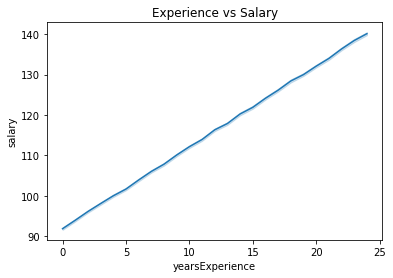

In [126]:
#correlation between years of experience and salary
ex = sns.lineplot(x='yearsExperience', y='salary', data=df)
ex.set_title('Experience vs Salary')
plt.show()

The plot shows there is positive relation between years of experience and salary

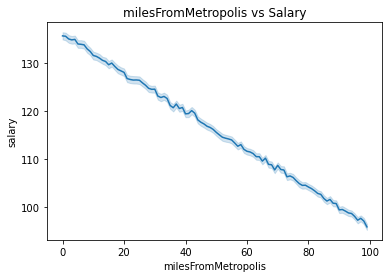

In [127]:
#correlation between milesFromMetropolis and salary
ex = sns.lineplot(x='milesFromMetropolis', y='salary', data=df)
ex.set_title('milesFromMetropolis vs Salary')
plt.show()

Above plot shows negative relation between milesFromMetropolis and salary

In [128]:
#correlation between companyId and salary
df1 = df.groupby(['companyId','jobType']).agg({'salary':'mean'})
df1.columns=['salary']
df1 = df1.reset_index()
df1[df1['jobType']=='MANAGER']['salary'].to_frame('mean salary')

,mean salary
5,115.838305
13,115.510802
21,114.698522
29,114.172959
37,116.148390
...,...
469,115.450409
477,117.280284
485,115.290256
493,114.773489


From above dataframe we can see that all companies mean salaries for a particular jobtype are same. CompnayId is not much of an important feature in determining the salary and can be removed

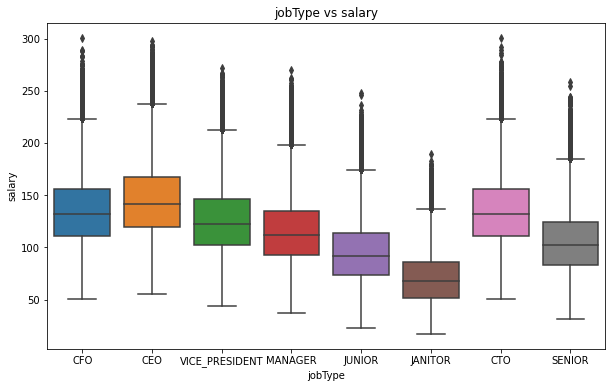

In [129]:
#correlation between jobType and salary
figure(figsize=(10,6))
fig = sns.boxplot(x='jobType',y='salary',data=df)
fig.set_title('jobType vs salary')
plt.show()

It clearly states that CTO, CFO, CEO have higher salaries compared to Janitor

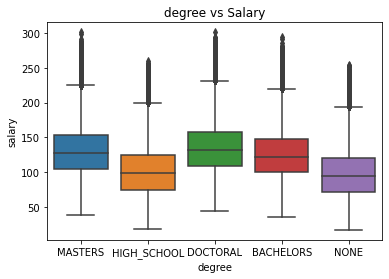

In [130]:
#correlation between degree and salary
fig = sns.boxplot(x='degree',y='salary',data=df)
fig.set_title('degree vs Salary')
plt.show()

Doctoral and Masters degree salaries are comparatively higher

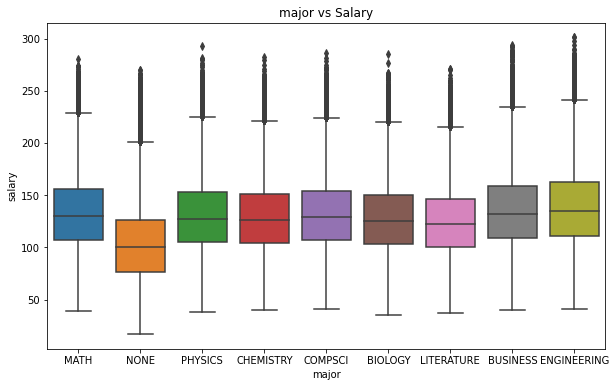

In [131]:
#correlation between major and salary
figure(figsize=(10,6))
fig = sns.boxplot(x='major',y='salary',data=df)
fig.set_title('major vs Salary')
plt.show()

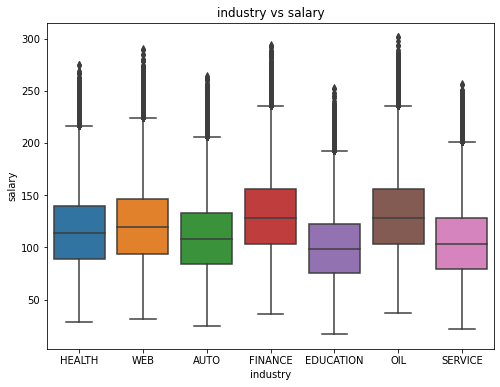

In [132]:
#correlation between industry and salary
figure(figsize=(8,6))
fig = sns.boxplot(x='industry',y='salary',data=df)
fig.set_title('industry vs salary')
plt.show()

Finance and oil industries are paying salaries higher comparitively

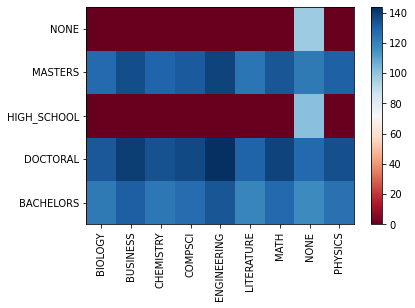

salary                                                  \
major           BIOLOGY    BUSINESS   CHEMISTRY     COMPSCI ENGINEERING   
degree                                                                    
BACHELORS    123.204343  130.890071  123.906966  126.965316  133.522468   
DOCTORAL     132.900799  140.227459  134.241379  136.887929  143.678077   
HIGH_SCHOOL    0.000000    0.000000    0.000000    0.000000    0.000000   
MASTERS      127.744510  135.809151  129.095825  132.436852  138.186407   
NONE           0.000000    0.000000    0.000000    0.000000    0.000000   

                                                             
major        LITERATURE        MATH        NONE     PHYSICS  
degree                                                       
BACHELORS    119.335256  128.211868  117.814699  125.209302  
DOCTORAL     129.674594  138.394916  128.314773  135.252974  
HIGH_SCHOOL    0.000000    0.000000  101.921085    0.000000  
MASTERS      124.215313  133.334637  123.119950  130.622320  
NONE           0.000000    0.000000   98.176882    0.000000

In [133]:
#correlation between degree, major and salary
df_degmaj = df[['degree','major','salary']]
df_groupdm = df_degmaj.groupby(['degree','major'], as_index=False).mean()
df_groupdm_pivot = df_groupdm.pivot(index = 'degree', columns = 'major')
df_groupdm_pivot = df_groupdm_pivot.fillna(0)


fig, ax = plt.subplots()
im = ax.pcolor(df_groupdm_pivot, cmap='RdBu')

#label names
row_labels = df_groupdm_pivot.columns.levels[1]
col_labels = df_groupdm_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(df_groupdm_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(df_groupdm_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.show()
df_groupdm_pivot

From the above heatmap Doctoral and Masters degrees in Engineering, Business shows relatively higher salaries

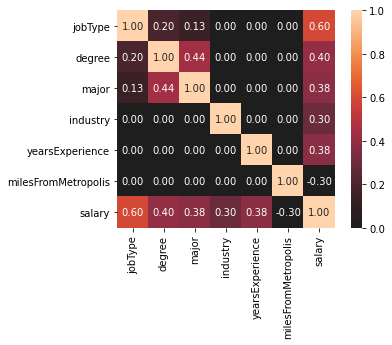

{'corr':                       jobType    degree     major  industry  yearsExperience  \
 jobType              1.000000  0.199119  0.133876  0.000940         0.001505   
 degree               0.199119  1.000000  0.444707  0.000259         0.000877   
 major                0.133876  0.444707  1.000000  0.000000         0.001192   
 industry             0.000940  0.000259  0.000000  1.000000         0.001871   
 yearsExperience      0.001505  0.000877  0.001192  0.001871         1.000000   
 milesFromMetropolis  0.002587  0.002094  0.002531  0.001487         0.000672   
 salary               0.597463  0.401300  0.378675  0.296626         0.375013   
 
                      milesFromMetropolis    salary  
 jobType                         0.002587  0.597463  
 degree                          0.002094  0.401300  
 major                           0.002531  0.378675  
 industry                        0.001487  0.296626  
 yearsExperience                 0.000672  0.375013  
 milesFromMetropol

In [225]:
#look for correlation between features
nominal.associations(df, nominal_columns=['jobId','companyId','jobType','degree','major','industry'])

From the above heatmap, the correlation between features is clearly seen. JobId and companyId are not at all influencing salary and so they can be removed. 

Positive correlation: jobType, degree, major, industry, yearsExperience

Negative correlation: milesFromMetropolis

### ---- 5 Establish a baseline ----

Creating a baseline model for us to compare with the models that we develop further. To create base model I am comparing the actual salaries with industry average salaries. For that taking the mean square error value to see the efficiency of the base model.

In [134]:
#selecting a reasonable metric (MSE in this case)
#creating an extremely simple model and measuring its efficacy
#using "average salary" for each industry as the model and then measure MSE

avg_salary = pd.DataFrame(df['salary'].groupby(df.industry).mean())
predicted_salary = df.merge(avg_salary, on='industry', how='inner')

mse_baseline = mean_squared_error(predicted_salary['salary_x'], predicted_salary['salary_y'])
print("The mean squared error of baseline model is :", np.round(mse_baseline,3))

The mean squared error of baseline model is : 1367.123


### ---- 6 Hypothesize solution ----

Inorder to attain better prediction of salary, I would like to use below machine learning algorithms and compare their performance to train the model. The best model to predict the outcome is the one with least mean squared error (MSE).

Linear Regression: It is the best, quick and easy to understand. It also works with large dataset.

Random Forest: Easy to understand and implement. Works well with large data and achieve good accuracy overcoming over-fitting problem

Gradient Boosting Tree: This helps in avoiding over-fitting and improves weak learners to strong learners.

Based on the EDA, need to remove jobId and companyId as they are not important. 
yearsExperience and milesFromMetropolis need to be scaled to fall in similar range
All other categorical variables need to be changed to numeric variables for algorithms to perform effectively.

Goal is to get MSE < 360 for the best model.

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [135]:
#making data ready for modeling
#creating new features needed to potentially enhance model
df_copy = df
#dropping jobId and companyId as they donot add anything to the model
df_copy.drop(columns=['jobId','companyId'], inplace=True)
df_copy.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,CFO,MASTERS,MATH,HEALTH,10,83,130
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [136]:
#creating dummy variables for categorical columns
df_dummies = pd.get_dummies(df_copy[df_copy.columns[0:4]], drop_first = True)
df_copy = df_copy.drop(df.columns[0:4],axis = 1)
# Join the encoded df_dummies to df_copy
df_copy = pd.concat([df_dummies,df_copy], axis=1)
df_copy.head()

,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,degree_HIGH_SCHOOL,degree_MASTERS,...,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis,salary
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,10,83,130
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,3,73,101
2,0,0,0,0,0,0,1,1,0,0,...,1,0,0,1,0,0,0,10,38,137
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,8,17,142
4,0,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,8,16,163


In [137]:
#scaling yearsExperience and milesFromMetropolis
scaler = MinMaxScaler()
df_copy[['yearsExperience','milesFromMetropolis']] = scaler.fit_transform(df_copy[['yearsExperience','milesFromMetropolis']])
df_copy.head()

,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,degree_HIGH_SCHOOL,degree_MASTERS,...,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis,salary
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0.416667,0.838384,130
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.125000,0.737374,101
2,0,0,0,0,0,0,1,1,0,0,...,1,0,0,1,0,0,0,0.416667,0.383838,137
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0.333333,0.171717,142
4,0,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0.333333,0.161616,163


Made the data ready by removing jobId, companyId features. 
Changing categorical variables jobType, degree, major and industry to numeric variables
Scaled yearsExperience and milesFromMetropolis features

In [138]:
x_data = df_copy.iloc[:,:27]
y_data = df_copy.iloc[:,-1]

In [139]:
#train, test spilt 
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.3, random_state=0)
print("The number of samples in training are:" , x_train.shape)
print("The number of samples in testing are:" , x_test.shape)
print("The number of samples in training are:" , y_train.shape)
print("The number of samples in testing are:" , y_test.shape)

The number of samples in training are: (699996, 27)
The number of samples in testing are: (299999, 27)
The number of samples in training are: (699996,)
The number of samples in testing are: (299999,)


### ---- 8 Create models ----

Creating and tuning the models

### 1. Linear Regression

In [146]:
lr = LinearRegression()
lr.fit(x_train,y_train)
lr.score(x_train,y_train)

0.7439387881506948

In [167]:
#calculating the mean squared error (mse) using 5 fold cross validation
cv = cross_val_score(lr, x_test, y_test, scoring = 'neg_mean_squared_error', cv=5)
mse_lr = cv.mean()*-1.0

In [168]:
data_lr = {'Model': ['Linear Regression'], 'MSE':[mse_lr] }
results = pd.DataFrame(data_lr,columns=['Model','MSE'])
results

,Model,MSE
0,Linear Regression,384.362627


### 2. Random Forest

In [159]:
#calculating the cross val score of random forest
rf = RandomForestRegressor(n_estimators=200, n_jobs = 2, max_depth=40, min_samples_split = 50, max_features='auto', verbose=0)
rf.fit(x_train,y_train)
rf.score(x_train,y_train)

0.7883864232221385

In [169]:
#calculating the mean squared error (mse) using 5 fold cross validation
cv = cross_val_score(rf, x_test, y_test, scoring = 'neg_mean_squared_error', cv=5)
mse_rf = cv.mean()*-1.0

In [189]:
data_rf = {'Model': 'Random Forest', 'MSE':mse_rf }
results = results.append(data_rf,ignore_index=True)

In [190]:
results

,Model,MSE
0,Linear Regression,384.363
1,Random Forest,377.168


### 3. Gradient Boosting Tree

In [195]:
gbr = GradientBoostingRegressor(n_estimators= 160, max_depth= 6, loss='ls', verbose=0)
gbr.fit(x_train,y_train)
gbr.score(x_train,y_train)

0.7645339547389242

In [196]:
#calculating the mean squared error (mse) using 5 fold cross validation
cv = cross_val_score(gbr, x_test, y_test, scoring = 'neg_mean_squared_error', cv=5)
mse_gbr = cv.mean()*-1.0

In [202]:
data_gbr = {'Model': 'Gradient Boosting Tree', 'MSE':mse_gbr }
results = results.append(data_gbr,ignore_index=True)

In [203]:
results

,Model,MSE
0,Linear Regression,384.363
1,Random Forest,377.168
2,Gradient Boosting Tree,359.684


### ---- 9 Select best model  ----

In [204]:
#select the model with the lowest error as your "production" model

results.min()

Model    Gradient Boosting Tree
MSE                     359.684
dtype: object

Gradient Boosting Tree has performed better so far when compared to Linear Regression and Random Forests. Our goal to achieve MSE <360 is attained by Gradient Boosting algorithm.

### ---- 10 Test models ----

Divided the available data into training and testing sets. Created the model and tested on it.
Done 5-fold cross validation on models with data and measured mean squared error to get its efficiency.
The results are stored in a dataframe: results

There is more test data which have jobids and their salaries need to be predicted. For that data we dont have true salaries, so we cannot calculate the efficacy of the model for this test data.

Preparing test data for the model

In [253]:
test_data = test_features.copy()
test_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407681,COMP33,MANAGER,DOCTORAL,ENGINEERING,WEB,6,20
1,JOB1362685407682,COMP13,SENIOR,MASTERS,ENGINEERING,WEB,5,20
2,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
3,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
4,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9


In [254]:
#creating dummy variables for categorical columns
test_data.drop(columns=['jobId','companyId'], inplace=True)
test_dummies = pd.get_dummies(test_data[test_data.columns[0:4]], drop_first = True)
test_data = test_data.drop(test_data.columns[0:4],axis = 1)
# Join the encoded df_dummies to df_copy
test_data = pd.concat([test_dummies,test_data], axis=1)
scaler = MinMaxScaler()
test_data[['yearsExperience','milesFromMetropolis']] = scaler.fit_transform(test_data[['yearsExperience','milesFromMetropolis']])
test_data.head()

,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,degree_HIGH_SCHOOL,degree_MASTERS,...,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0.250000,0.202020
1,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0.208333,0.202020
2,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0.916667,0.737374
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.833333,0.474747
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0.708333,0.090909


In [255]:
#Predicting salaries
test_salary = pd.DataFrame(gbr.predict(test_data))

In [256]:
prediction_test=pd.concat([test_features['jobId'],test_salary],axis=1, names=['jobId','salary'])
prediction_test.head(5)

,jobId,0
0,JOB1362685407681,148.091882
1,JOB1362685407682,132.172751
2,JOB1362685407687,112.739262
3,JOB1362685407688,91.744755
4,JOB1362685407689,177.114181


## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
# save the model to disk
filename = 'finalized_model_gbr.sav'
joblib.dump(gbr, filename)

### ---- 12 Deploy solution ----

In [214]:
#saving prediction to a csv file
prediction_test.to_csv('predicted_salaries.csv')

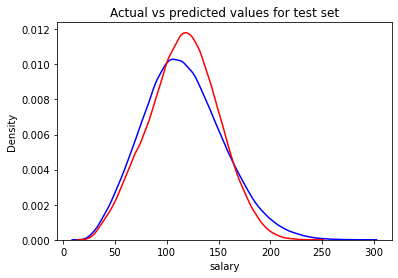

In [224]:
#saving visualization and summary of the prediction and feature importances

#visualizing actual and predicted values of x_test dataset

sns.distplot(y_test, color='b',hist=False)
sns.distplot(gbr.predict(x_test), color='r',hist=False)
plt.title('Actual vs predicted values for test set')
plt.show()

Text(0.5, 1.0, 'FEATURE IMPORTANCE PLOT')

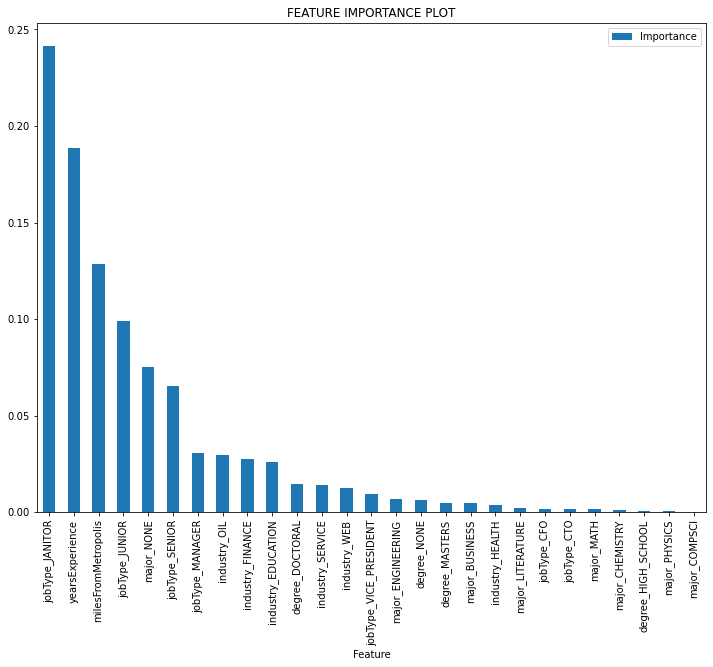

In [235]:
feature_imp = gbr.feature_importances_
feature_importance = pd.DataFrame({'Feature':test_data.columns, "Importance" : feature_imp})

#Sorting values by ascending values
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.set_index('Feature', inplace=True, drop=True)
fig = feature_importance.plot.bar(figsize=(12,9))
fig.set_title('FEATURE IMPORTANCE PLOT')

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data